In [1]:
import os
import pandas as pd

In [4]:
df = pd.read_csv(os.path.join('../data', 'gene_coords_and_descriptions.bed'), sep='\t', header=None, names=['chr', 'start', 'end', 'gene', 'description'])

In [5]:
df.head()

,chr,start,end,gene,description
0,chrX,100627108,100636806,TSPAN6,The protein encoded by this gene is a member o...
1,chrX,100584936,100599885,TNMD,This gene encodes a protein that is related to...
2,chr20,50934870,50958532,DPM1,Dolichol-phosphate mannose (Dol-P-Man) serves ...
3,chr1,169849631,169893896,CCL15,This gene is located in a cluster of similar g...
4,chr1,27612064,27635185,FGR,This gene is a member of the Src family of pro...


In [6]:
df.shape

(21765, 5)

In [9]:
# combine gene and description into one column
df_text = df['gene'] + ': ' + df['description']
# rename df_text column to "text"
df_text = df_text.rename('text')

In [10]:
df_text.head()

0    TSPAN6: The protein encoded by this gene is a ...
1    TNMD: This gene encodes a protein that is rela...
2    DPM1: Dolichol-phosphate mannose (Dol-P-Man) s...
3    CCL15: This gene is located in a cluster of si...
4    FGR: This gene is a member of the Src family o...
Name: text, dtype: object

In [11]:
df_text.to_csv(os.path.join('../data', 'gene_descriptions-text.csv'), index=False, header=True)

In [ ]:
# embed with node script
# node embed-csv.mjs data/gene_descriptions-text.csv "text"

In [12]:
# umap and stuff
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json

In [24]:
name = "gene_descriptions-text"

In [25]:
with open('../data/{name}-embeddings.json'.format(name=name), 'r') as f:
    metadata = json.load(f)
with open('../data/{name}-embeddings.bin'.format(name=name), 'rb') as f:
    embeddings = np.fromfile(f, dtype=np.float64)
#reshape the embeddings
embeddings = embeddings.reshape((len(metadata), metadata[0]["dimensions"]))

In [26]:
embeddings.shape

(21765, 1536)

In [27]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.075,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [28]:
umap_embeddings = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.075, n_neighbors=50, random_state=42, verbose=True)
Fri Jun 16 17:11:56 2023 Construct fuzzy simplicial set
Fri Jun 16 17:11:56 2023 Finding Nearest Neighbors
Fri Jun 16 17:11:56 2023 Building RP forest with 12 trees


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Fri Jun 16 17:11:56 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 16 17:12:09 2023 Finished Nearest Neighbor Search
Fri Jun 16 17:12:11 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Jun 16 17:12:24 2023 Finished embedding


In [29]:
umap_embeddings.shape

(21765, 2)

In [30]:
# normalize the umap_embeddings to be between -1 and 1
umap_embeddings = (umap_embeddings - umap_embeddings.min()) / (umap_embeddings.max() - umap_embeddings.min())

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_43979/3739994091.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')


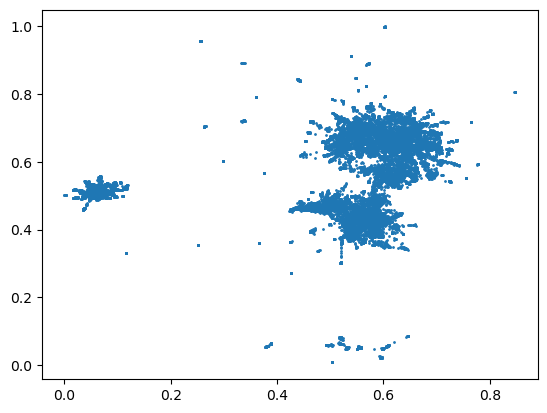

In [31]:
# plot embedding
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')
plt.show()

In [38]:
def cluster(umap_embeddings, min_cluster_size=20, min_samples=10):
  # Create an HDBSCAN instance with custom parameters
  # cluster based on UMAP
  clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
  clusterer.fit(umap_embeddings)

  cluster_labels = clusterer.labels_
  return cluster_labels



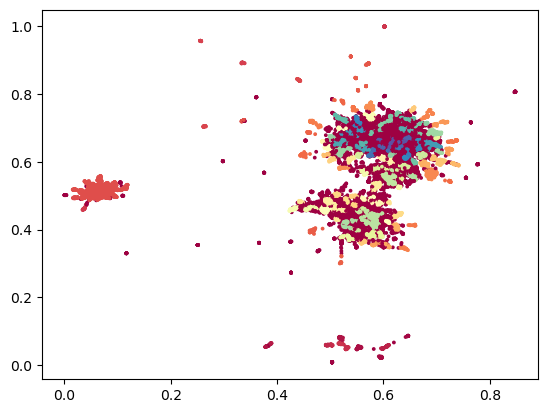

In [44]:
cluster_labels = cluster(umap_embeddings, 25, 15)
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# Find the centroids of the non-noise clusters
unique_labels = np.unique(cluster_labels)
  

In [45]:
unique_labels.shape

(157,)

In [46]:
def assign_clusters(umap_embeddings, cluster_labels):
    unique_labels = np.unique(cluster_labels)
    non_noise_labels = unique_labels[unique_labels != -1]
    centroids = [umap_embeddings[cluster_labels == label].mean(axis=0) for label in non_noise_labels]
    from scipy.spatial.distance import cdist
    # Assign noise points to the closest cluster centroid
    noise_points = umap_embeddings[cluster_labels == -1]
    closest_centroid_indices = np.argmin(cdist(noise_points, centroids), axis=1)

    # Update cluster_labels with the new assignments for noise points
    noise_indices = np.where(cluster_labels == -1)[0]
    new_assignments = [non_noise_labels[index] for index in closest_centroid_indices]
    assigned_labels = cluster_labels.copy()
    assigned_labels[noise_indices] = new_assignments
    return assigned_labels

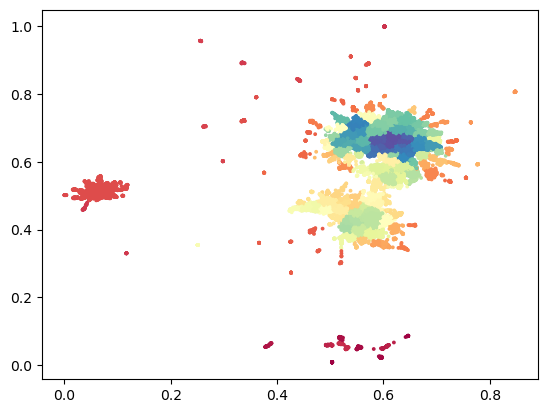

In [47]:
# plot embedding with cluster labels
assigned_labels = assign_clusters(umap_embeddings, cluster_labels)
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=assigned_labels, s=3, cmap='Spectral')


In [48]:
#write embedding to csv file with header x,y
np.savetxt("../data/{name}-umap.csv".format(name=name), umap_embeddings, delimiter=",", header="x,y", comments='')

In [49]:
np.savetxt("../data/{name}-hdbscan.csv".format(name=name), assigned_labels, delimiter=",", header="cluster", comments="")
